In [ ]:
!pip install adlfs


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.4/207.4 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.3/55.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 407.0/407.0 kB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.1/186.1 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.4/115.4 kB 10.8 MB/s eta 0:00:00


#### IMPORTS

In [ ]:
# Basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml
import random
import plotly.express as px
import joblib
from datetime import timedelta
from typing import List, Tuple, Dict,Optional

# Azure
from adlfs import AzureBlobFileSystem

from typing import Tuple, List, Optional
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import pandas as pd


# Models
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler,LabelEncoder
from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc ,  precision_score, recall_score
from tensorflow.keras.metrics import AUC, Precision, Recall

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import AUC, Precision, Recall



#### FUNCTIONS

In [ ]:

def prepare_data(df, targets, scaler_type='standard', drop_cols=['date', 'symbol'], encode_symbol: bool = False):
    """
    Prepares data for ML models by imputing missing values and scaling features.

    Args:
        - df (pd.DataFrame): Full input DataFrame.
        - targets (list): List of target columns.
        - scaler_type (str): 'standard' or 'minmax'.
        - drop_cols (list): Columns to drop from the DataFrame.
        - encode_symbol (bool): Whether to keep and encode 'symbol' as a feature.

    Returns:
        - df_scaled (pd.DataFrame): Scaled features with targets.
        - scaler: The fitted scaler object.
    """
    df_clean = df.copy()

    # Opcionalmente preservar 'symbol' si se desea codificarlo
    if encode_symbol and 'symbol' in df_clean.columns:
        drop_cols = [col for col in drop_cols if col != 'symbol']

    # Eliminar columnas no deseadas
    df_clean = df_clean.drop(columns=drop_cols, errors='ignore')

    # Codificar variables categóricas (incluido symbol si se conserva)
    for col in df_clean.select_dtypes(include=['object', 'category']).columns:
        df_clean[col] = LabelEncoder().fit_transform(df_clean[col].astype(str))

    # Separar features y targets
    feature_cols = [col for col in df_clean.columns if col not in targets]
    X = df_clean[feature_cols]
    y = df_clean[targets]

    # Imputación de valores
    imputer = SimpleImputer(strategy='mean')
    X_imputed = imputer.fit_transform(X)

    # Escalado
    scaler = StandardScaler() if scaler_type == 'standard' else MinMaxScaler()
    X_scaled = scaler.fit_transform(X_imputed)

    # Reconstruir DataFrame escalado
    df_scaled = pd.DataFrame(X_scaled, columns=feature_cols, index=X.index)

    # Agregar los targets de nuevo
    df_scaled = pd.concat([df_scaled, y], axis=1)

    return df_scaled, scaler



In [ ]:
def model_evaluation(
    y_test: pd.Series,
    y_pred: pd.Series,
    y_prob: pd.Series
) -> Tuple[float, float, float]:
    """
    Evaluates the classification model and plots the metrics
    Args:
        - y_test (pd.Series): True target vals
        - y_pred (pd.Series): Predicted class vals
        - y_prov (pd.Series): Predicted probss for clas 1
    Returns:
        - Tuple[float, float, float]: Accuracy, F1 Score, and ROC AUC.
    """
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob)
    cm = confusion_matrix(y_test, y_pred)
    precission = precision_score(y_test, y_pred)
    recall= recall_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc:.4f}")
    print(f"Confusion Matrix:\n {cm}")
    print(f"Precision: {precission:.4f}")
    print(f"Recall: {recall:.4f}")

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(5, 4))
    cax = ax.matshow(cm, cmap='Blues')
    fig.colorbar(cax)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['No', 'Yes'])
    ax.set_yticklabels(['No', 'Yes'])
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return acc, f1, roc,cm,precission,recall



In [ ]:
def train_base_lstm_classifier_lite(
    df,
    target_column='target_3m',
    sequence_length=10,
    epochs=30,
    batch_size=16,
    patience=3
):
    """
    Trains a lightweight LSTM classfier.
    Designed to be memory efficient and optimized for environments with limited resources.
    Trais a LSTM model to predict wether the rarget return will exceed a threshold based on the previous sequence of data.

    Args:
      df (pd.DataFrame): Input dataframe with features and a binary target column.
      target_column (str): Name of the target column to predict (default 'target_3m').
      sequence_length (int): Number of past time steps to include in each sequence.
      epochs (int): Maximum number of training epochs.
      batch_size (int): Batch size for model training.
      patience (int): Number of epochs to wait for early stopping.

    Returns:
        model (Sequential): Trained Keras model.
        X_test (np.ndarray): Test features.
        y_test (np.ndarray): True binary labels for test set.
        y_prob (np.ndarray): Predicted probabilities from the model.
        y_pred (np.ndarray): Final class predictions (threshold at 0.5).
    """

    feature_cols = [col for col in df.columns if col != target_column]
    data = df[feature_cols + [target_column]].copy()
    data[target_column] = (data[target_column] > 0).astype(int)

    # Build X and y
    X, y = [], []
    for i in range(len(data) - sequence_length):
        seq = data.iloc[i:i+sequence_length].drop(columns=[target_column]).values.astype(np.float32)
        target = data.iloc[i+sequence_length][target_column]
        X.append(seq)
        y.append(target)

    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.int32)

    # train/test division
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # LSTM simple model
    model = Sequential([
        LSTM(32, input_shape=(X.shape[1], X.shape[2])),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=BinaryCrossentropy(),
        metrics=['accuracy', AUC()]
    )


    early_stop = EarlyStopping(monitor='val_accuracy', patience=patience, restore_best_weights=True)

    model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=1
    )

    y_prob = model.predict(X_test).flatten()
    y_pred = (y_prob > 0.5).astype(int)

    return model, X_test, y_test, y_prob, y_pred

In [ ]:
def clean_columns(df: pd.DataFrame) -> pd.DataFrame:
  """
  Cleans a DataFrame by dropping unnecessary columns and handling missing values.

  Args:
      df (pd.DataFrame): Input DataFrame.

  Returns:
      pd.DataFrame: Cleaned DataFrame.
  """
  columns_to_drop = [
      'date', 'symbol', 'capital_gains',
      'ret_next_3m', 'ret_next_6m', 'ret_next_1y',
      'price_lead_3m', 'price_lead_6m', 'price_lead_1y',
      'open_v', 'high', 'low', 'dividends', 'stock_splits',
      'is_dividend_day', 'is_stock_split', 'gap_open', 'price_range',
      'tr_1', 'tr_2', 'tr_3', 'sma_5', 'bollinger_upper',
      'bollinger_lower', 'ema_12', 'macd_line'
  ]
  print(f"Shape before: {df.shape}")
  df = df.drop(columns=columns_to_drop, errors='ignore').copy()
  numeric_cols = df.select_dtypes(include=["float64", "int64", "int32"]).columns
  imputer = SimpleImputer(strategy="mean")
  df[numeric_cols] = imputer.fit_transform(df[numeric_cols])
  print(f"Shape after: {df.shape}")
  return df


In [ ]:

def load_data_from_dl(account_name: str,container_name: str,relative_path: str,access_key: str)->pd.DataFrame:
    """
    Loads all Parquet files from an Azure Blob Storage path into a single DataFrame.
    Args:
        - account_name (str): Azure Storage account name.
        - container_name (str): Name of the container.
        - relative_path (str): Path inside the container to search for .parquet files.
        - access_key (str): Storage account access key.
    Returns:
        - df (pd.DataFrame): Combined DataFrame from all found Parquet files.
    Raises:
        - ValueError: If no Parquet files are found in the path.
    """
    abfs = AzureBlobFileSystem(account_name=account_name, account_key=access_key)


    all_files = abfs.glob(f"{container_name}/{relative_path}/*.parquet")
    print(f"folder: {all_files}")

    if not all_files:
        raise ValueError("Not found .parquet files")

    dfs = []
    for f in all_files:
        print(f"Reading files: {f}")
        with abfs.open(f, "rb") as fp:
            dfs.append(pd.read_parquet(fp))

    df = pd.concat(dfs, ignore_index=True)
    print(df.head())
    return df

In [ ]:
def train_improved_lstm_classifier_1(
    df,
    target_column='target_3m',
    sequence_length=20,
    epochs=30,
    batch_size=32,
    patience=4
):
    """
    Trains a moderately deep LSTM classifier with simplified architecture and faster convergence.

    Args:
        df (pd.DataFrame): Input dataframe with features and a binary target column.
        target_column (str): Name of the target column to predict (default 'target_3m').

    Returns:
        model (Sequential): Trained Keras model.
        X_test (np.ndarray): Test features.
        y_test (np.ndarray): True binary labels for test set.
        y_prob (np.ndarray): Predicted probabilities from the model.
    """

    feature_cols = [col for col in df.columns if col != target_column]
    data = df[feature_cols + [target_column]].copy()
    data[target_column] = (data[target_column] > 0).astype(int)

    X, y = [], []
    for i in range(len(data) - sequence_length):
        seq = data.iloc[i:i+sequence_length].drop(columns=[target_column]).values.astype(np.float32)
        label = data.iloc[i+sequence_length][target_column]
        X.append(seq)
        y.append(label)

    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.int32)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    model = Sequential([
        LSTM(64, return_sequences=False, input_shape=(X.shape[1], X.shape[2])),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=BinaryCrossentropy(),
        metrics=['accuracy', AUC(), Precision(), Recall()]
    )

    early_stop = EarlyStopping(monitor='val_auc', patience=patience, restore_best_weights=True, mode='max')

    model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=1
    )

    y_prob = model.predict(X_test).flatten()
    y_pred = (y_prob > 0.5).astype(int)

    return model, X_test, y_test, y_prob, y_pred

In [ ]:
def train_base_gru_classifier_lite(
    df,
    target_column='target_3m',
    sequence_length=10,
    epochs=30,
    batch_size=16,
    patience=3
):
    """
    Trains a lightweight GRU classifier.
    Designed for memory efficiency. Predicts if the target return exceeds a threshold using historical sequences.

    Args:
        df (pd.DataFrame): Input dataframe with features and a binary target column.
        target_column (str): Name of the target column to predict.
        sequence_length (int): Length of the input sequences.
        epochs (int): Max training epochs.
        batch_size (int): Batch size.
        patience (int): Early stopping patience.

    Returns:
        model (Sequential): Trained Keras model.
        X_test (np.ndarray): Test features.
        y_test (np.ndarray): True labels.
        y_prob (np.ndarray): Predicted probabilities.
        y_pred (np.ndarray): Binary predictions.
    """
    from sklearn.model_selection import train_test_split
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import GRU, Dense, Dropout
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.losses import BinaryCrossentropy
    from tensorflow.keras.callbacks import EarlyStopping
    from tensorflow.keras.metrics import AUC
    import numpy as np

    feature_cols = [col for col in df.columns if col != target_column]
    data = df[feature_cols + [target_column]].copy()
    data[target_column] = (data[target_column] > 0).astype(int)

    X, y = [], []
    for i in range(len(data) - sequence_length):
        seq = data.iloc[i:i+sequence_length].drop(columns=[target_column]).values.astype(np.float32)
        target = data.iloc[i+sequence_length][target_column]
        X.append(seq)
        y.append(target)

    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.int32)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    model = Sequential([
        GRU(32, input_shape=(X.shape[1], X.shape[2])),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=BinaryCrossentropy(),
        metrics=['accuracy', AUC()]
    )

    early_stop = EarlyStopping(monitor='val_accuracy', patience=patience, restore_best_weights=True)

    model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=1
    )

    y_prob = model.predict(X_test).flatten()
    y_pred = (y_prob > 0.5).astype(int)

    return model, X_test, y_test, y_prob, y_pred


#**MAIN**

In [ ]:
account_name = "smartwalletjorge"
container_name = "smart-wallet-dl"
relative_path = "smart_wallet/stock_data_parquet"
access_key = "WVlHk0d7oGwjnRiJDICGexZY1LArsLiK7zMBw+GzYRWk9GCllLFAI0tizVY0ffrP9xobZoVdK8PP+AStXHGmfw=="
'''with open("config.yaml", "r") as file:
    config = yaml.safe_load(file)

account_name = config['storage']['storage_account_name']
container_name = config['storage']['container_name']
relative_path = config['storage']['relative_path']
access_key = config['storage']['access_key']'''

# Cargar el DataFrame desde Azure
df_full = load_data_from_dl(account_name, container_name, relative_path, access_key)


folder: ['smart-wallet-dl/smart_wallet/stock_data_parquet/part-00000-tid-6319656906602864551-70988dce-8c71-437f-9993-81d0d24559f8-53-1-c000.snappy.parquet']
Reading files: smart-wallet-dl/smart_wallet/stock_data_parquet/part-00000-tid-6319656906602864551-70988dce-8c71-437f-9993-81d0d24559f8-53-1-c000.snappy.parquet


ClientAuthenticationError: Server failed to authenticate the request. Make sure the value of Authorization header is formed correctly including the signature.
RequestId:0f373631-201e-0045-5fa2-e6fdaa000000
Time:2025-06-26T13:56:39.7847726Z
ErrorCode:AuthenticationFailed
authenticationerrordetail:The MAC signature found in the HTTP request 'n8KrWexFYKcqLryq6zwG2BB4Pz+fpckZBojQlAj9ZZk=' is not the same as any computed signature. Server used following string to sign: 'GET











x-ms-client-request-id:620c0094-5295-11f0-8e01-0242ac1c000c
x-ms-date:Thu, 26 Jun 2025 13:56:39 GMT
x-ms-range:bytes=799879650-833434081
x-ms-version:2025-05-05
/smartwalletjorge/smart-wallet-dl/smart_wallet/stock_data_parquet/part-00000-tid-6319656906602864551-70988dce-8c71-437f-9993-81d0d24559f8-53-1-c000.snappy.parquet'.
Content: <?xml version="1.0" encoding="utf-8"?><Error><Code>AuthenticationFailed</Code><Message>Server failed to authenticate the request. Make sure the value of Authorization header is formed correctly including the signature.
RequestId:0f373631-201e-0045-5fa2-e6fdaa000000
Time:2025-06-26T13:56:39.7847726Z</Message><AuthenticationErrorDetail>The MAC signature found in the HTTP request 'n8KrWexFYKcqLryq6zwG2BB4Pz+fpckZBojQlAj9ZZk=' is not the same as any computed signature. Server used following string to sign: 'GET











x-ms-client-request-id:620c0094-5295-11f0-8e01-0242ac1c000c
x-ms-date:Thu, 26 Jun 2025 13:56:39 GMT
x-ms-range:bytes=799879650-833434081
x-ms-version:2025-05-05
/smartwalletjorge/smart-wallet-dl/smart_wallet/stock_data_parquet/part-00000-tid-6319656906602864551-70988dce-8c71-437f-9993-81d0d24559f8-53-1-c000.snappy.parquet'.</AuthenticationErrorDetail></Error>

In [ ]:
df_full.to_parquet("df_full_spark.parquet")

In [ ]:
df_full=pd.read_parquet("df_full_spark.parquet")

#### **1. Define targets**


In [ ]:
df_full = df_full.dropna(subset=['ret_next_3m', 'ret_next_6m', 'ret_next_1y'])
df_full.loc[:, "target_3m"] = (df_full["ret_next_3m"] > 0.10).astype(int)
df_full.loc[:, "target_6m"] = (df_full["ret_next_6m"] > 0.15).astype(int)
df_full.loc[:, "target_1y"] = (df_full["ret_next_1y"] > 0.25).astype(int)


#### **2. Train train_base_lstm_classifier_lite for 20 symbols**

In [ ]:
# Select top 20 symbols and prepare the data
top_symbols = (
    df_full.groupby("symbol")
    .size()
    .sort_values(ascending=False)
    .head(20)
    .index
)
df_clean = df_full[df_full["symbol"].isin(top_symbols)].copy()

# Order, first by symbol, then by date
df_clean = df_clean.sort_values(by=["symbol", "date"])

# Clean columns
df_clean = clean_columns(df_clean)

# Processing and Scaling
targets = ['target_3m', 'target_6m', 'target_1y']
df_processed_minmax, scaler_minmax = prepare_data(df_clean, targets, scaler_type='minmax', encode_symbol=True)


Shape before: (125066, 56)
Shape after: (125066, 30)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
6507/6507 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - accuracy: 0.7785 - auc: 0.8138 - loss: 0.4640 - val_accuracy: 0.7820 - val_auc: 0.8112 - val_loss: 0.4785
Epoch 2/30
6507/6507 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - accuracy: 0.7907 - auc: 0.8310 - loss: 0.4478 - val_accuracy: 0.7820 - val_auc: 0.8129 - val_loss: 0.4659
Epoch 3/30
6507/6507 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - accuracy: 0.7918 - auc: 0.8308 - loss: 0.4460 - val_accuracy: 0.7827 - val_auc: 0.8131 - val_loss: 0.4685
Epoch 4/30
6507/6507 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - accuracy: 0.7920 - auc: 0.8313 - loss: 0.4455 - val_accuracy: 0.7817 - val_auc: 0.8131 - val_loss: 0.4766
Epoch 5/30
6507/6507 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - accuracy: 0.7936 - auc: 0.8350 - loss: 0.4427 - val_accuracy: 0.7842 - val_auc: 0.8107 - val_loss: 0.4674
Epoch 6/30
6507/6507 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - accuracy: 0.7944 - auc: 0.8370 - loss: 0.4411 - val_accuracy: 0.7857 - val_auc: 0.8143 - val_loss: 0.4646
Epoch 7/30
6507/6507 ━

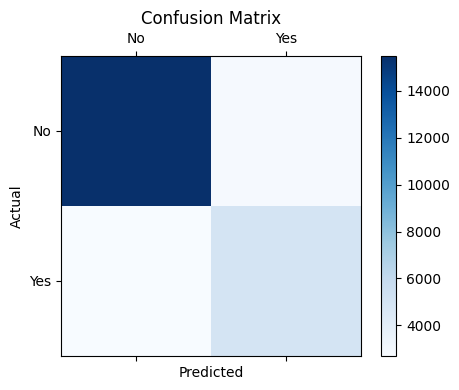

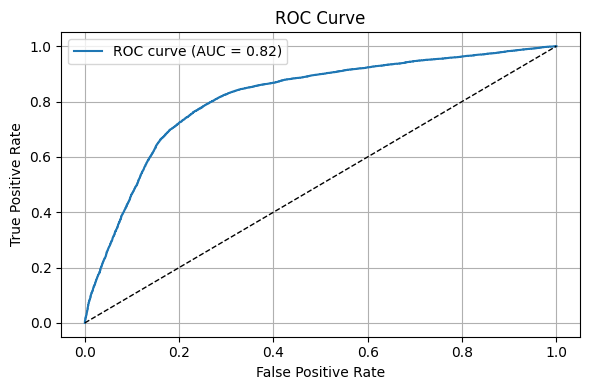

(0.7872291378515445,
 0.6436752026766182,
 np.float64(0.815896594419001),
 array([[15488,  2832],
        [ 2706,  5002]]),
 0.6384988511616033,
 0.648936170212766)

In [ ]:
#Model for 3 Months
target_column = 'target_3m'
model, X_test, y_test, y_prob, y_pred = train_base_lstm_classifier_lite(
    df_processed_minmax,
    target_column=target_column
)

# Evaluación
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
6507/6507 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - accuracy: 0.7872 - auc_1: 0.8695 - loss: 0.4390 - val_accuracy: 0.7842 - val_auc_1: 0.8654 - val_loss: 0.4448
Epoch 2/30
6507/6507 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - accuracy: 0.7953 - auc_1: 0.8754 - loss: 0.4298 - val_accuracy: 0.7807 - val_auc_1: 0.8650 - val_loss: 0.4486
Epoch 3/30
6507/6507 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - accuracy: 0.7977 - auc_1: 0.8799 - loss: 0.4218 - val_accuracy: 0.7857 - val_auc_1: 0.8657 - val_loss: 0.4455
Epoch 4/30
6507/6507 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - accuracy: 0.7979 - auc_1: 0.8783 - loss: 0.4253 - val_accuracy: 0.7886 - val_auc_1: 0.8659 - val_loss: 0.4404
Epoch 5/30
6507/6507 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - accuracy: 0.8010 - auc_1: 0.8811 - loss: 0.4212 - val_accuracy: 0.7892 - val_auc_1: 0.8659 - val_loss: 0.4443
Epoch 6/30
6507/6507 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - accuracy: 0.8019 - auc_1: 0.8820 - loss: 0.4192 - val_accuracy: 0.7877 - val_auc_1: 0.8666 - val_loss: 0.439

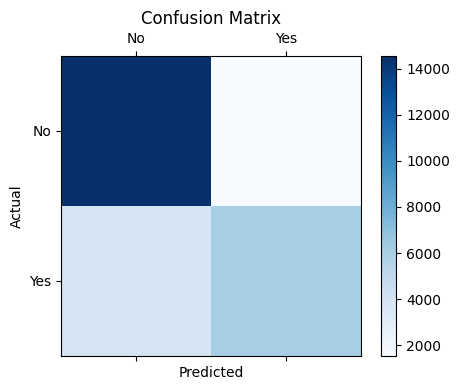

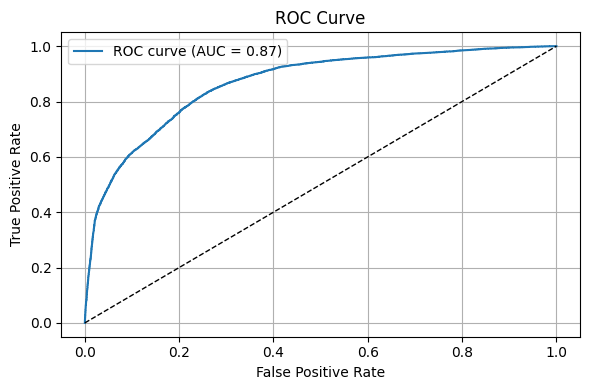

(0.7914937759336099,
 0.6906811057281277,
 np.float64(0.8666779852925204),
 array([[14542,  1551],
        [ 3876,  6059]]),
 0.7961892247043364,
 0.609864116758933)

In [ ]:
#Model for 6 Months
target_column = 'target_6m'
model, X_test, y_test, y_prob, y_pred = train_base_lstm_classifier_lite(
    df_processed_minmax,
    target_column=target_column
)

# Evaluación
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6507/6507 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - accuracy: 0.7572 - auc_2: 0.7904 - loss: 0.5397 - val_accuracy: 0.7435 - val_auc_2: 0.7764 - val_loss: 0.5707
Epoch 2/30
6507/6507 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - accuracy: 0.7679 - auc_2: 0.8042 - loss: 0.5239 - val_accuracy: 0.7425 - val_auc_2: 0.7747 - val_loss: 0.5692
Epoch 3/30
6507/6507 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - accuracy: 0.7713 - auc_2: 0.8078 - loss: 0.5198 - val_accuracy: 0.7347 - val_auc_2: 0.7729 - val_loss: 0.5661
Epoch 4/30
6507/6507 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - accuracy: 0.7710 - auc_2: 0.8128 - loss: 0.5171 - val_accuracy: 0.7425 - val_auc_2: 0.7786 - val_loss: 0.5579
814/814 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy: 0.7435
F1 Score: 0.7029
ROC AUC: 0.7762
Confusion Matrix:
 [[11454  3038]
 [ 3639  7897]]
Precision: 0.7222
Recall: 0.6846


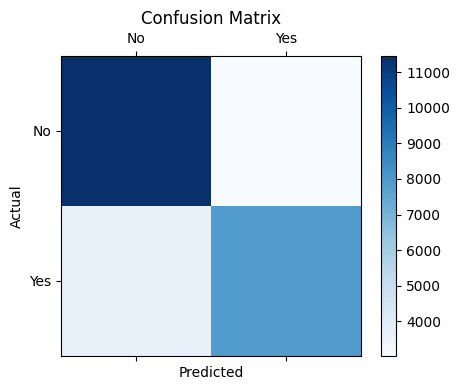

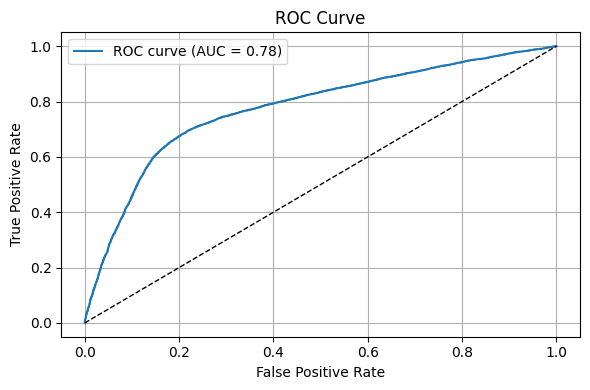

(0.7434685723067466,
 0.7028614658893685,
 np.float64(0.7762429301230045),
 array([[11454,  3038],
        [ 3639,  7897]]),
 0.7221764974851395,
 0.6845527045769764)

In [ ]:
#Model for 1 Year
target_column = 'target_1y'
model, X_test, y_test, y_prob, y_pred = train_base_lstm_classifier_lite(
    df_processed_minmax,
    target_column=target_column
)

# Evaluación
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)

#### **3. Train train_base_lstm_classifier_lite for 100 symbols**

In [ ]:
# Select top 100 symbols and prepare the data
top_symbols = (
    df_full.groupby("symbol")
    .size()
    .sort_values(ascending=False)
    .head(100)
    .index
)
df_clean = df_full[df_full["symbol"].isin(top_symbols)].copy()

# Order, first by symbol, then by date
df_clean = df_clean.sort_values(by=["symbol", "date"])
# Clean columns
df_clean = clean_columns(df_clean)

# Processing and Scaling
targets = ['target_3m', 'target_6m', 'target_1y']
df_processed_minmax, scaler_minmax = prepare_data(df_clean, targets, scaler_type='minmax', encode_symbol=True)


Shape before: (646534, 56)
Shape after: (646534, 30)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
32327/32327 ━━━━━━━━━━━━━━━━━━━━ 175s 5ms/step - accuracy: 0.7878 - auc_1: 0.8099 - loss: 0.4507 - val_accuracy: 0.8002 - val_auc_1: 0.8180 - val_loss: 0.4250
Epoch 2/30
32327/32327 ━━━━━━━━━━━━━━━━━━━━ 173s 5ms/step - accuracy: 0.7937 - auc_1: 0.8192 - loss: 0.4428 - val_accuracy: 0.8010 - val_auc_1: 0.8183 - val_loss: 0.4249
Epoch 3/30
32327/32327 ━━━━━━━━━━━━━━━━━━━━ 173s 5ms/step - accuracy: 0.7953 - auc_1: 0.8223 - loss: 0.4397 - val_accuracy: 0.8009 - val_auc_1: 0.8192 - val_loss: 0.4243
Epoch 4/30
32327/32327 ━━━━━━━━━━━━━━━━━━━━ 173s 5ms/step - accuracy: 0.7948 - auc_1: 0.8224 - loss: 0.4410 - val_accuracy: 0.7995 - val_auc_1: 0.8183 - val_loss: 0.4286
Epoch 5/30
32327/32327 ━━━━━━━━━━━━━━━━━━━━ 173s 5ms/step - accuracy: 0.7956 - auc_1: 0.8237 - loss: 0.4388 - val_accuracy: 0.8015 - val_auc_1: 0.8189 - val_loss: 0.4249
Epoch 6/30
32327/32327 ━━━━━━━━━━━━━━━━━━━━ 173s 5ms/step - accuracy: 0.7959 - auc_1: 0.8232 - loss: 0.4396 - val_accuracy: 0.8007 - val_auc_1: 0.8189

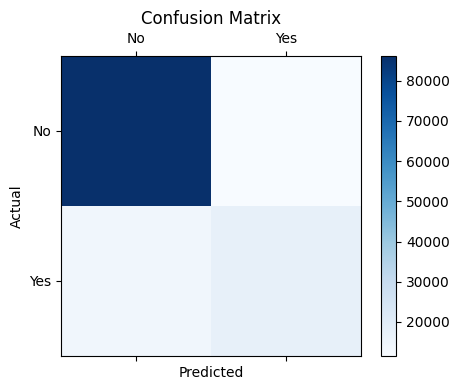

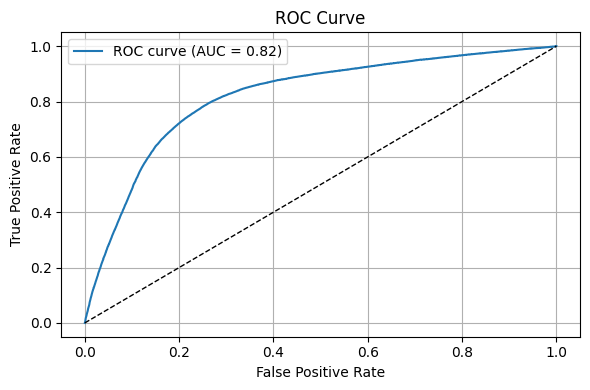

(0.8014616604152972,
 0.5770675453047776,
 np.float64(0.8189269449493435),
 array([[86119, 11643],
        [14029, 17514]]),
 0.6006790822101039,
 0.5552420505341914)

In [ ]:
#Model for 3 Months
target_column = 'target_3m'
model, X_test, y_test, y_prob, y_pred = train_base_lstm_classifier_lite(
    df_processed_minmax,
    target_column=target_column
)

# Evaluación
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
32327/32327 ━━━━━━━━━━━━━━━━━━━━ 174s 5ms/step - accuracy: 0.7829 - auc_7: 0.8530 - loss: 0.4524 - val_accuracy: 0.7949 - val_auc_7: 0.8606 - val_loss: 0.4335
Epoch 2/30
32327/32327 ━━━━━━━━━━━━━━━━━━━━ 173s 5ms/step - accuracy: 0.7874 - auc_7: 0.8587 - loss: 0.4451 - val_accuracy: 0.7964 - val_auc_7: 0.8613 - val_loss: 0.4309
Epoch 3/30
32327/32327 ━━━━━━━━━━━━━━━━━━━━ 172s 5ms/step - accuracy: 0.7895 - auc_7: 0.8604 - loss: 0.4427 - val_accuracy: 0.7972 - val_auc_7: 0.8612 - val_loss: 0.4296
Epoch 4/30
32327/32327 ━━━━━━━━━━━━━━━━━━━━ 171s 5ms/step - accuracy: 0.7901 - auc_7: 0.8614 - loss: 0.4416 - val_accuracy: 0.7965 - val_auc_7: 0.8618 - val_loss: 0.4300
Epoch 5/30
32327/32327 ━━━━━━━━━━━━━━━━━━━━ 171s 5ms/step - accuracy: 0.7910 - auc_7: 0.8623 - loss: 0.4407 - val_accuracy: 0.7946 - val_auc_7: 0.8612 - val_loss: 0.4303
Epoch 6/30
32327/32327 ━━━━━━━━━━━━━━━━━━━━ 171s 5ms/step - accuracy: 0.7921 - auc_7: 0.8632 - loss: 0.4394 - val_accuracy: 0.7970 - val_auc_7: 0.8618

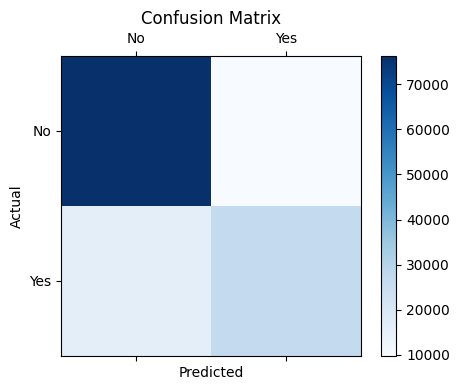

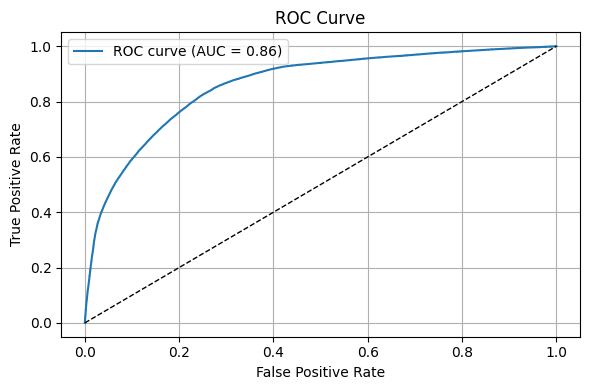

(0.7972313522292255,
 0.6717249496049782,
 np.float64(0.861323160013993),
 array([[76261,  9820],
        [16399, 26825]]),
 0.7320234684131532,
 0.6206042939107903)

In [ ]:
#Model for 6 Months
target_column = 'target_6m'
model, X_test, y_test, y_prob, y_pred = train_base_lstm_classifier_lite(
    df_processed_minmax,
    target_column=target_column
)

# Evaluación
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
32327/32327 ━━━━━━━━━━━━━━━━━━━━ 176s 5ms/step - accuracy: 0.7522 - auc: 0.7845 - loss: 0.5449 - val_accuracy: 0.7561 - val_auc: 0.7836 - val_loss: 0.5401
Epoch 2/30
32327/32327 ━━━━━━━━━━━━━━━━━━━━ 171s 5ms/step - accuracy: 0.7573 - auc: 0.7938 - loss: 0.5357 - val_accuracy: 0.7550 - val_auc: 0.7841 - val_loss: 0.5402
Epoch 3/30
32327/32327 ━━━━━━━━━━━━━━━━━━━━ 172s 5ms/step - accuracy: 0.7580 - auc: 0.7948 - loss: 0.5347 - val_accuracy: 0.7545 - val_auc: 0.7843 - val_loss: 0.5394
Epoch 4/30
32327/32327 ━━━━━━━━━━━━━━━━━━━━ 172s 5ms/step - accuracy: 0.7565 - auc: 0.7935 - loss: 0.5366 - val_accuracy: 0.7554 - val_auc: 0.7857 - val_loss: 0.5402
4041/4041 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
Accuracy: 0.7561
F1 Score: 0.6876
ROC AUC: 0.7837
Confusion Matrix:
 [[63055 11928]
 [19611 34711]]
Precision: 0.7442
Recall: 0.6390


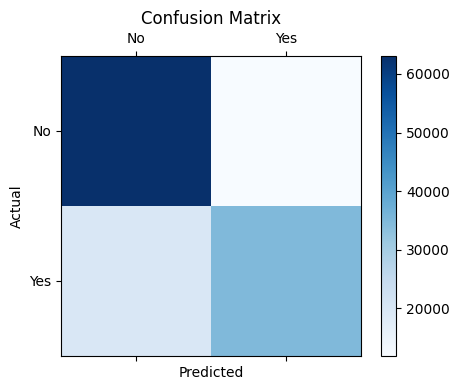

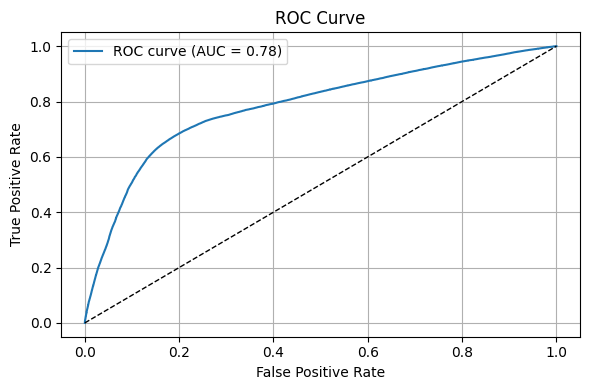

(0.7560883183171571,
 0.6876120482166381,
 np.float64(0.7836798462163407),
 array([[63055, 11928],
        [19611, 34711]]),
 0.7442483758228092,
 0.6389860461691396)

In [ ]:
#Model for 1 Year
target_column = 'target_1y' #######################
model, X_test, y_test, y_prob, y_pred = train_base_lstm_classifier_lite(
    df_processed_minmax,
    target_column=target_column
)

# Evaluación
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)

4. Train train_improved_lstm_classifier_1 for 20 symbols

In [ ]:
# Select top 20 symbols and prepare the data
top_symbols = (
    df_full.groupby("symbol")
    .size()
    .sort_values(ascending=False)
    .head(20)
    .index
)
df_clean = df_full[df_full["symbol"].isin(top_symbols)].copy()

# Order, first by symbol, then by date
df_clean = df_clean.sort_values(by=["symbol", "date"])

# Clean columns
df_clean = clean_columns(df_clean)

# Processing and Scaling
targets = ['target_3m', 'target_6m', 'target_1y']
df_processed_minmax, scaler_minmax = prepare_data(df_clean, targets, scaler_type='minmax', encode_symbol=True)



Shape before: (130146, 56)
Shape after: (130146, 30)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - accuracy: 0.7899 - auc_9: 0.8281 - loss: 0.4515 - precision_1: 0.6386 - recall_1: 0.6852 - val_accuracy: 0.7902 - val_auc_9: 0.8288 - val_loss: 0.4785 - val_precision_1: 0.6447 - val_recall_1: 0.6496
Epoch 2/30
  19/3254 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.7962 - auc_9: 0.8543 - loss: 0.4350 - precision_1: 0.6424 - recall_1: 0.7266

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: accuracy,auc_9,loss,precision_1,recall_1,val_accuracy,val_auc_9,val_loss,val_precision_1,val_recall_1
  current = self.get_monitor_value(logs)


3254/3254 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.8001 - auc_9: 0.8442 - loss: 0.4340 - precision_1: 0.6573 - recall_1: 0.6961 - val_accuracy: 0.7906 - val_auc_9: 0.8312 - val_loss: 0.4546 - val_precision_1: 0.6473 - val_recall_1: 0.6437
Epoch 3/30
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.8017 - auc_9: 0.8473 - loss: 0.4303 - precision_1: 0.6601 - recall_1: 0.6938 - val_accuracy: 0.7961 - val_auc_9: 0.8342 - val_loss: 0.4476 - val_precision_1: 0.6684 - val_recall_1: 0.6184
Epoch 4/30
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.8052 - auc_9: 0.8515 - loss: 0.4256 - precision_1: 0.6679 - recall_1: 0.6949 - val_accuracy: 0.7950 - val_auc_9: 0.8361 - val_loss: 0.4483 - val_precision_1: 0.6581 - val_recall_1: 0.6406
Epoch 5/30
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.8068 - auc_9: 0.8529 - loss: 0.4234 - precision_1: 0.6706 - recall_1: 0.6969 - val_accuracy: 0.7958 - val_auc_9: 0.8371 - val_loss: 0.4532 - val_precision_1: 0.6605 - val_

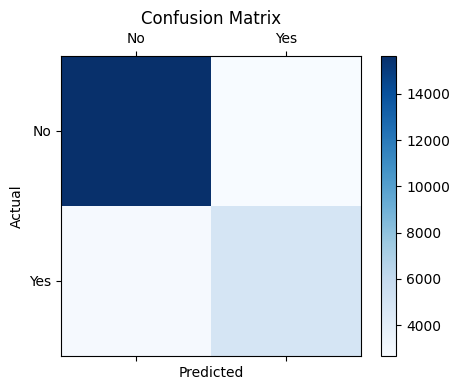

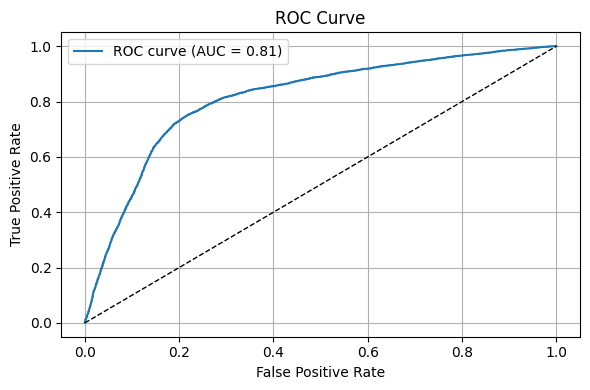

(0.788980250518712,
 0.6413270637408568,
 np.float64(0.8126616238303492),
 array([[15624,  2694],
        [ 2798,  4910]]),
 0.6457127827459233,
 0.6370005189413597)

In [ ]:
#Model for 3 Months
target_column = 'target_3m'
model, X_test, y_test, y_prob, y_pred = train_improved_lstm_classifier_1(
    df_processed_minmax,
    target_column=target_column
)

# Evaluación
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - accuracy: 0.7935 - auc_10: 0.8721 - loss: 0.4381 - precision_2: 0.7511 - recall_2: 0.7557 - val_accuracy: 0.7901 - val_auc_10: 0.8698 - val_loss: 0.4393 - val_precision_2: 0.7096 - val_recall_2: 0.7618
Epoch 2/30
  19/3254 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.8090 - auc_10: 0.8936 - loss: 0.4019 - precision_2: 0.7668 - recall_2: 0.8269

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: accuracy,auc_10,loss,precision_2,recall_2,val_accuracy,val_auc_10,val_loss,val_precision_2,val_recall_2
  current = self.get_monitor_value(logs)


3254/3254 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.8039 - auc_10: 0.8845 - loss: 0.4176 - precision_2: 0.7649 - recall_2: 0.7639 - val_accuracy: 0.7948 - val_auc_10: 0.8711 - val_loss: 0.4329 - val_precision_2: 0.7433 - val_recall_2: 0.7063
Epoch 3/30
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.8088 - auc_10: 0.8859 - loss: 0.4153 - precision_2: 0.7731 - recall_2: 0.7599 - val_accuracy: 0.7932 - val_auc_10: 0.8725 - val_loss: 0.4300 - val_precision_2: 0.7731 - val_recall_2: 0.6488
Epoch 4/30
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.8076 - auc_10: 0.8854 - loss: 0.4159 - precision_2: 0.7736 - recall_2: 0.7550 - val_accuracy: 0.7968 - val_auc_10: 0.8727 - val_loss: 0.4371 - val_precision_2: 0.7431 - val_recall_2: 0.7146
Epoch 5/30
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.8087 - auc_10: 0.8869 - loss: 0.4133 - precision_2: 0.7705 - recall_2: 0.7653 - val_accuracy: 0.7911 - val_auc_10: 0.8737 - val_loss: 0.4327 - val_precision_2: 0.707

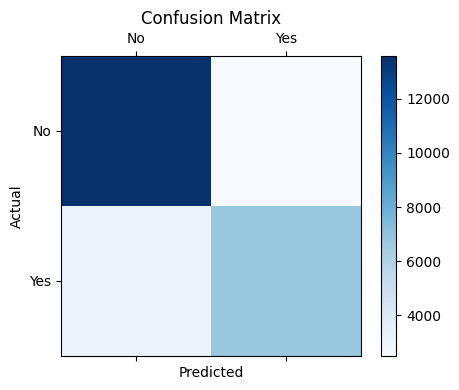

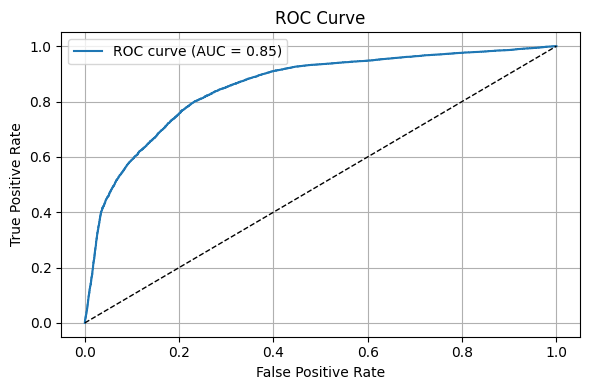

(0.7835241681395527,
 0.7077194438680224,
 np.float64(0.8538409580863644),
 array([[13571,  2520],
        [ 3114,  6821]]),
 0.7302216036826892,
 0.6865626572722697)

In [ ]:
#Model for 6 Months
target_column = 'target_6m'
model, X_test, y_test, y_prob, y_pred = train_improved_lstm_classifier_1(
    df_processed_minmax,
    target_column=target_column
)

# Evaluación
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - accuracy: 0.7573 - auc_11: 0.7973 - loss: 0.5349 - precision_3: 0.7924 - recall_3: 0.7042 - val_accuracy: 0.7433 - val_auc_11: 0.7808 - val_loss: 0.5648 - val_precision_3: 0.7224 - val_recall_3: 0.6835
Epoch 2/30
  19/3254 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.7193 - auc_11: 0.7421 - loss: 0.5865 - precision_3: 0.7804 - recall_3: 0.6359

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: accuracy,auc_11,loss,precision_3,recall_3,val_accuracy,val_auc_11,val_loss,val_precision_3,val_recall_3
  current = self.get_monitor_value(logs)


3254/3254 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.7716 - auc_11: 0.8133 - loss: 0.5169 - precision_3: 0.7919 - recall_3: 0.7435 - val_accuracy: 0.7405 - val_auc_11: 0.7836 - val_loss: 0.5609 - val_precision_3: 0.7107 - val_recall_3: 0.6989
Epoch 3/30
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.7688 - auc_11: 0.8147 - loss: 0.5172 - precision_3: 0.7911 - recall_3: 0.7407 - val_accuracy: 0.7415 - val_auc_11: 0.7833 - val_loss: 0.5556 - val_precision_3: 0.7126 - val_recall_3: 0.6985
Epoch 4/30
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.7714 - auc_11: 0.8213 - loss: 0.5115 - precision_3: 0.7911 - recall_3: 0.7441 - val_accuracy: 0.7399 - val_auc_11: 0.7833 - val_loss: 0.5625 - val_precision_3: 0.7073 - val_recall_3: 0.7050
Epoch 5/30
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.7703 - auc_11: 0.8219 - loss: 0.5107 - precision_3: 0.7898 - recall_3: 0.7446 - val_accuracy: 0.7408 - val_auc_11: 0.7836 - val_loss: 0.5591 - val_precision_3: 0.708

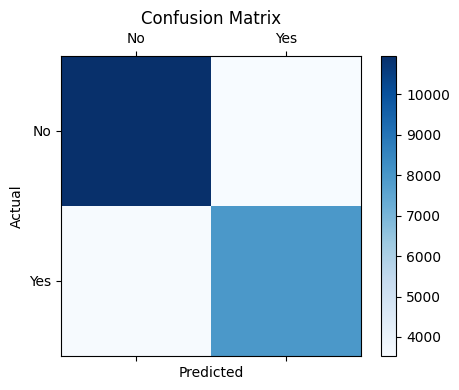

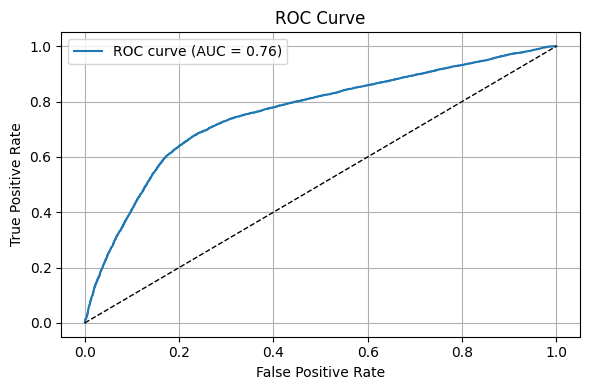

(0.725812648889572,
 0.6899548140424053,
 np.float64(0.759358736811173),
 array([[10950,  3540],
        [ 3596,  7940]]),
 0.6916376306620209,
 0.6882801664355063)

In [ ]:
#Model for 1 yr
target_column = 'target_1y'
model, X_test, y_test, y_prob, y_pred = train_improved_lstm_classifier_1(
    df_processed_minmax,
    target_column=target_column
)

# Evaluación
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)

5. Train train_improved_lstm_classifier_1 for 500 symbols

Shape before: (3194588, 56)
Shape after: (3194588, 30)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
79865/79865 ━━━━━━━━━━━━━━━━━━━━ 532s 7ms/step - accuracy: 0.7855 - auc: 0.8612 - loss: 0.4500 - precision: 0.7428 - recall: 0.6951 - val_accuracy: 0.7910 - val_auc: 0.8667 - val_loss: 0.4414 - val_precision: 0.7470 - val_recall: 0.6833
Epoch 2/30
79865/79865 ━━━━━━━━━━━━━━━━━━━━ 527s 7ms/step - accuracy: 0.7920 - auc: 0.8677 - loss: 0.4410 - precision: 0.7490 - recall: 0.7076 - val_accuracy: 0.7911 - val_auc: 0.8662 - val_loss: 0.4415 - val_precision: 0.7415 - val_recall: 0.6941
Epoch 3/30
79865/79865 ━━━━━━━━━━━━━━━━━━━━ 528s 7ms/step - accuracy: 0.7924 - auc: 0.8685 - loss: 0.4399 - precision: 0.7485 - recall: 0.7111 - val_accuracy: 0.7906 - val_auc: 0.8665 - val_loss: 0.4412 - val_precision: 0.7380 - val_recall: 0.6992
Epoch 4/30
79865/79865 ━━━━━━━━━━━━━━━━━━━━ 528s 7ms/step - accuracy: 0.7928 - auc: 0.8688 - loss: 0.4392 - precision: 0.7484 - recall: 0.7113 - val_accuracy: 0.7913 - val_auc: 0.8667 - val_loss: 0.4415 - val_precision: 0.7462 - val_recall: 0.6862
Epoch 5/

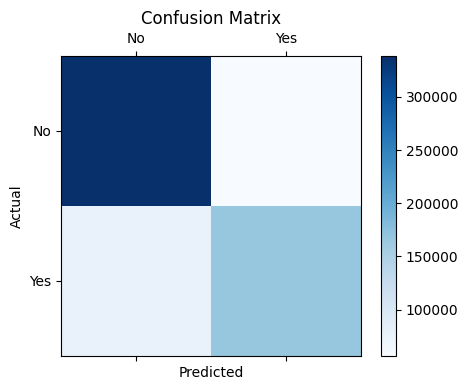

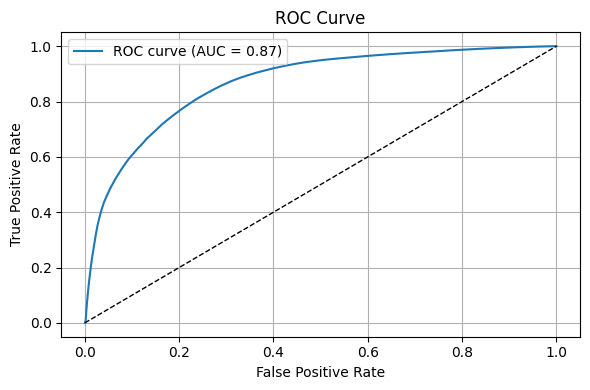

(0.7913162021805752,
 0.7149371960019242,
 np.float64(0.8666972697376294),
 array([[338386,  56868],
        [ 76463, 167197]]),
 0.746198647713833,
 0.6861897726339982)

In [ ]:
# Seleccionamos los 500 símbolos con más histórico
top_symbols = (
    df_full.groupby("symbol")
    .size()
    .sort_values(ascending=False)
    .head(500)
    .index
)
df_clean = df_full[df_full["symbol"].isin(top_symbols)].copy()
df_clean = df_clean.sort_values(by=["symbol", "date"]).reset_index(drop=True)
df_clean = clean_columns(df_clean)

# Preparamos los datos
targets = ['target_3m', 'target_6m', 'target_1y']
df_processed_minmax, scaler_minmax = prepare_data(df_clean, targets, scaler_type='minmax', encode_symbol=True)

# Entrenamos el modelo mejorado para 6 meses
model_500, X_test_500, y_test_500, y_prob_500, y_pred_500 = train_improved_lstm_classifier_1(
    df_processed_minmax,
    target_column='target_6m'
)

# Evaluamos
model_evaluation(
    y_test=pd.Series(y_test_500),
    y_pred=pd.Series(y_pred_500),
    y_prob=pd.Series(y_prob_500)
)


Shape before: (3194588, 56)
Shape after: (3194588, 30)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
159729/159729 ━━━━━━━━━━━━━━━━━━━━ 977s 6ms/step - accuracy: 0.7787 - auc_1: 0.8544 - loss: 0.4574 - val_accuracy: 0.7845 - val_auc_1: 0.8590 - val_loss: 0.4520
Epoch 2/30
159729/159729 ━━━━━━━━━━━━━━━━━━━━ 974s 6ms/step - accuracy: 0.7824 - auc_1: 0.8583 - loss: 0.4524 - val_accuracy: 0.7832 - val_auc_1: 0.8575 - val_loss: 0.4548
Epoch 3/30
159729/159729 ━━━━━━━━━━━━━━━━━━━━ 972s 6ms/step - accuracy: 0.7831 - auc_1: 0.8590 - loss: 0.4516 - val_accuracy: 0.7846 - val_auc_1: 0.8590 - val_loss: 0.4505
Epoch 4/30
159729/159729 ━━━━━━━━━━━━━━━━━━━━ 972s 6ms/step - accuracy: 0.7839 - auc_1: 0.8594 - loss: 0.4509 - val_accuracy: 0.7847 - val_auc_1: 0.8590 - val_loss: 0.4503
Epoch 5/30
159729/159729 ━━━━━━━━━━━━━━━━━━━━ 973s 6ms/step - accuracy: 0.7839 - auc_1: 0.8595 - loss: 0.4511 - val_accuracy: 0.7772 - val_auc_1: 0.8575 - val_loss: 0.4544
Epoch 6/30
159729/159729 ━━━━━━━━━━━━━━━━━━━━ 969s 6ms/step - accuracy: 0.7838 - auc_1: 0.8597 - loss: 0.4507 - val_accuracy: 0.7847 - val_a

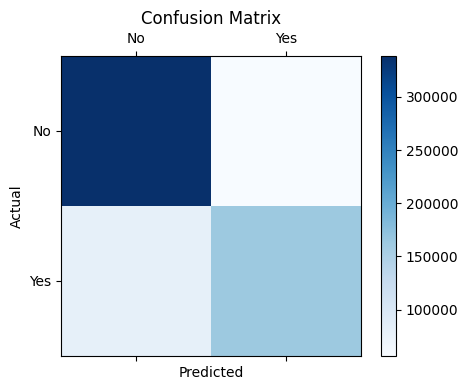

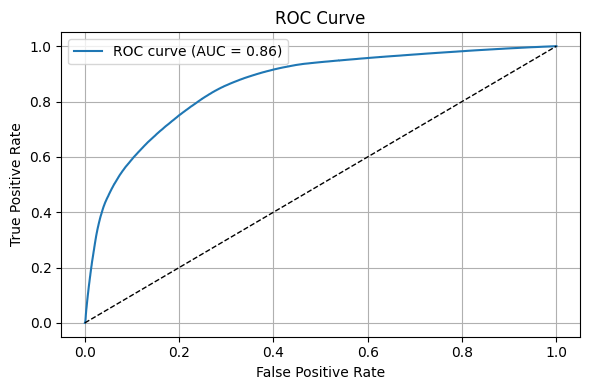

(0.7847494819350275,
 0.7032224790192512,
 np.float64(0.859012138372989),
 array([[338452,  56804],
        [ 80723, 162937]]),
 0.7414956699022941,
 0.6687063941557908)

In [ ]:
# Seleccionamos los 500 símbolos con más histórico
top_symbols = (
    df_full.groupby("symbol")
    .size()
    .sort_values(ascending=False)
    .head(500)
    .index
)
df_clean = df_full[df_full["symbol"].isin(top_symbols)].copy()
df_clean = df_clean.sort_values(by=["symbol", "date"]).reset_index(drop=True)
df_clean = clean_columns(df_clean)

# Preparamos los datos
targets = ['target_3m', 'target_6m', 'target_1y']
df_processed_minmax, scaler_minmax = prepare_data(df_clean, targets, scaler_type='minmax', encode_symbol=True)

# Entrenamos el modelo mejorado para 6 meses
model_500, X_test_500, y_test_500, y_prob_500, y_pred_500 = train_base_lstm_classifier_lite(
    df_processed_minmax,
    target_column='target_6m'
)

# Evaluamos
model_evaluation(
    y_test=pd.Series(y_test_500),
    y_pred=pd.Series(y_pred_500),
    y_prob=pd.Series(y_prob_500)
)


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

from google.colab import drive

# Cambia esta ruta si quieres otra carpeta
save_path = '/content/drive/MyDrive/modelos_lstm'

# Crear carpeta si no existe
import os
os.makedirs(save_path, exist_ok=True)

# Guardar modelo y scaler
model_500.save(f'{save_path}/lstm_model_500_target6m.keras')

import joblib
joblib.dump(scaler_minmax, f'{save_path}/scaler_minmax_500.pkl')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['/content/drive/MyDrive/modelos_lstm/scaler_minmax_500.pkl']

6. Train train_gru_classifier for 20 symbols

Shape before: (130146, 56)
Shape after: (130146, 30)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
6507/6507 ━━━━━━━━━━━━━━━━━━━━ 42s 6ms/step - accuracy: 0.7858 - auc: 0.8680 - loss: 0.4413 - val_accuracy: 0.7882 - val_auc: 0.8647 - val_loss: 0.4478
Epoch 2/30
6507/6507 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - accuracy: 0.7963 - auc: 0.8771 - loss: 0.4271 - val_accuracy: 0.7873 - val_auc: 0.8650 - val_loss: 0.4438
Epoch 3/30
6507/6507 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - accuracy: 0.7987 - auc: 0.8799 - loss: 0.4219 - val_accuracy: 0.7893 - val_auc: 0.8656 - val_loss: 0.4407
Epoch 4/30
6507/6507 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - accuracy: 0.7961 - auc: 0.8778 - loss: 0.4251 - val_accuracy: 0.7894 - val_auc: 0.8659 - val_loss: 0.4424
Epoch 5/30
6507/6507 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - accuracy: 0.8000 - auc: 0.8795 - loss: 0.4233 - val_accuracy: 0.7902 - val_auc: 0.8664 - val_loss: 0.4423
Epoch 6/30
6507/6507 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - accuracy: 0.7999 - auc: 0.8803 - loss: 0.4232 - val_accuracy: 0.7886 - val_auc: 0.8665 - val_loss: 0.4395
Epoch 7/30
6507/6507 ━

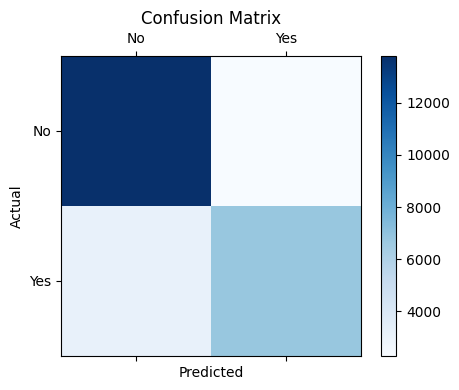

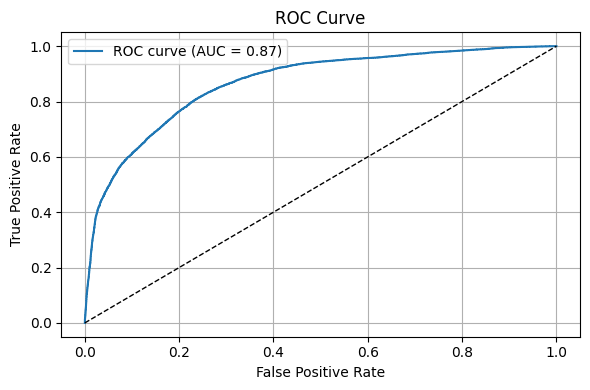

(0.7901874903949593,
 0.7124427360328577,
 np.float64(0.8663806978004767),
 array([[13802,  2291],
        [ 3170,  6765]]),
 0.7470185512367491,
 0.6809260191243081)

In [ ]:
# Select top 20 symbols and prepare the data
top_symbols = (
    df_full.groupby("symbol")
    .size()
    .sort_values(ascending=False)
    .head(20)
    .index
)
df_clean = df_full[df_full["symbol"].isin(top_symbols)].copy()

# Order, first by symbol, then by date
df_clean = df_clean.sort_values(by=["symbol", "date"])

# Clean columns
df_clean = clean_columns(df_clean)

# Processing and Scaling
targets = ['target_3m', 'target_6m', 'target_1y']
df_processed_minmax, scaler_minmax = prepare_data(df_clean, targets, scaler_type='minmax', encode_symbol=True)


#Model for 6 Months
target_column = 'target_6m'
model, X_test, y_test, y_prob, y_pred = train_base_gru_classifier_lite(
    df_processed_minmax,
    target_column=target_column
)

# Evaluación
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)

Shape before: (646534, 56)
Shape after: (646534, 30)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
32327/32327 ━━━━━━━━━━━━━━━━━━━━ 188s 6ms/step - accuracy: 0.7828 - auc_1: 0.8530 - loss: 0.4525 - val_accuracy: 0.7953 - val_auc_1: 0.8602 - val_loss: 0.4304
Epoch 2/30
32327/32327 ━━━━━━━━━━━━━━━━━━━━ 185s 6ms/step - accuracy: 0.7896 - auc_1: 0.8617 - loss: 0.4412 - val_accuracy: 0.7969 - val_auc_1: 0.8616 - val_loss: 0.4292
Epoch 3/30
32327/32327 ━━━━━━━━━━━━━━━━━━━━ 184s 6ms/step - accuracy: 0.7895 - auc_1: 0.8615 - loss: 0.4412 - val_accuracy: 0.7923 - val_auc_1: 0.8615 - val_loss: 0.4338
Epoch 4/30
32327/32327 ━━━━━━━━━━━━━━━━━━━━ 183s 6ms/step - accuracy: 0.7915 - auc_1: 0.8629 - loss: 0.4391 - val_accuracy: 0.7959 - val_auc_1: 0.8612 - val_loss: 0.4288
Epoch 5/30
32327/32327 ━━━━━━━━━━━━━━━━━━━━ 182s 6ms/step - accuracy: 0.7915 - auc_1: 0.8625 - loss: 0.4402 - val_accuracy: 0.7969 - val_auc_1: 0.8614 - val_loss: 0.4279
Epoch 6/30
32327/32327 ━━━━━━━━━━━━━━━━━━━━ 183s 6ms/step - accuracy: 0.7914 - auc_1: 0.8627 - loss: 0.4401 - val_accuracy: 0.7962 - val_auc_1: 0.8617

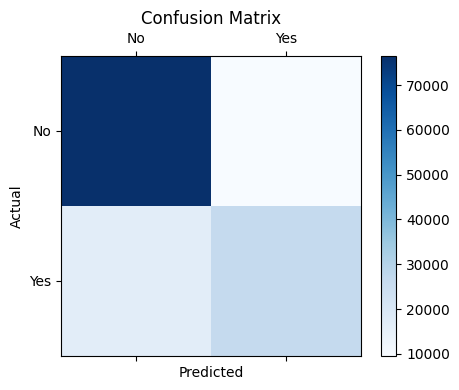

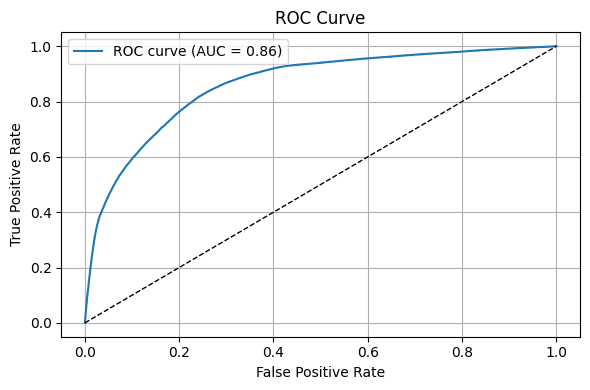

(0.7969374734155679,
 0.6694280426544461,
 np.float64(0.861516078935833),
 array([[76462,  9619],
        [16638, 26586]]),
 0.734318464300511,
 0.6150749583564686)

In [ ]:
# Select top 100 symbols and prepare the data
top_symbols = (
    df_full.groupby("symbol")
    .size()
    .sort_values(ascending=False)
    .head(100)
    .index
)
df_clean = df_full[df_full["symbol"].isin(top_symbols)].copy()

# Order, first by symbol, then by date
df_clean = df_clean.sort_values(by=["symbol", "date"])

# Clean columns
df_clean = clean_columns(df_clean)

# Processing and Scaling
targets = ['target_3m', 'target_6m', 'target_1y']
df_processed_minmax, scaler_minmax = prepare_data(df_clean, targets, scaler_type='minmax', encode_symbol=True)


#Model for 6 Months
target_column = 'target_6m'
model, X_test, y_test, y_prob, y_pred = train_base_gru_classifier_lite(
    df_processed_minmax,
    target_column=target_column
)

# Evaluación
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)

Shape before: (3194588, 56)
Shape after: (3194588, 30)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
159729/159729 ━━━━━━━━━━━━━━━━━━━━ 942s 6ms/step - accuracy: 0.7791 - auc: 0.8546 - loss: 0.4572 - val_accuracy: 0.7837 - val_auc: 0.8590 - val_loss: 0.4498
Epoch 2/30
159729/159729 ━━━━━━━━━━━━━━━━━━━━ 935s 6ms/step - accuracy: 0.7827 - auc: 0.8585 - loss: 0.4523 - val_accuracy: 0.7850 - val_auc: 0.8588 - val_loss: 0.4501
Epoch 3/30
159729/159729 ━━━━━━━━━━━━━━━━━━━━ 941s 6ms/step - accuracy: 0.7829 - auc: 0.8587 - loss: 0.4519 - val_accuracy: 0.7828 - val_auc: 0.8586 - val_loss: 0.4510
Epoch 4/30
159729/159729 ━━━━━━━━━━━━━━━━━━━━ 941s 6ms/step - accuracy: 0.7835 - auc: 0.8592 - loss: 0.4511 - val_accuracy: 0.7834 - val_auc: 0.8582 - val_loss: 0.4503
Epoch 5/30
159729/159729 ━━━━━━━━━━━━━━━━━━━━ 933s 6ms/step - accuracy: 0.7831 - auc: 0.8593 - loss: 0.4513 - val_accuracy: 0.7841 - val_auc: 0.8586 - val_loss: 0.4502
19967/19967 ━━━━━━━━━━━━━━━━━━━━ 28s 1ms/step
Accuracy: 0.7850
F1 Score: 0.6993
ROC AUC: 0.8589
Confusion Matrix:
 [[341767  53489]
 [ 83905 159755]]
Precision:

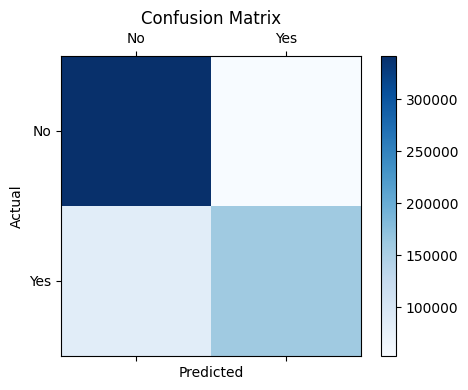

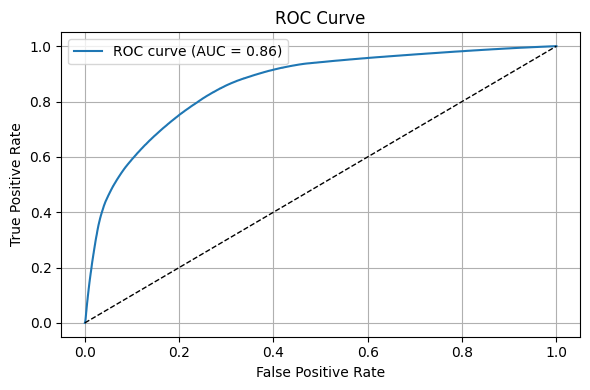

(0.784957647014631,
 0.6992935058568102,
 np.float64(0.8588689397188853),
 array([[341767,  53489],
        [ 83905, 159755]]),
 0.7491652754590985,
 0.65564721333005)

In [ ]:
# Select top 500 symbols and prepare the data
top_symbols = (
    df_full.groupby("symbol")
    .size()
    .sort_values(ascending=False)
    .head(500)
    .index
)
df_clean = df_full[df_full["symbol"].isin(top_symbols)].copy()

# Order, first by symbol, then by date
df_clean = df_clean.sort_values(by=["symbol", "date"])

# Clean columns
df_clean = clean_columns(df_clean)

# Processing and Scaling
targets = ['target_3m', 'target_6m', 'target_1y']
df_processed_minmax, scaler_minmax = prepare_data(df_clean, targets, scaler_type='minmax', encode_symbol=True)


#Model for 6 Months
target_column = 'target_6m'
model, X_test, y_test, y_prob, y_pred = train_base_gru_classifier_lite(
    df_processed_minmax,
    target_column=target_column
)

# Evaluación
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)m


## FULL TRAINING

In [ ]:
def save_trained_model_and_scaler(model, scaler, model_name, target_column, folder_path='/content/drive/MyDrive/modelos_lstm'):
    """
    Save trained LSTM model and corresponding scaler.

    Args:
        model: Trained Keras model object.
        scaler: Fitted scaler (e.g., MinMaxScaler).
        model_name (str): Identifier name for model (e.g. "improved_lstm").
        target_column (str): Target variable name (e.g. "target_6m").
        folder_path (str): Directory path where to save model and scaler.
    """
    import os
    import joblib
    from tensorflow.keras.models import save_model

    os.makedirs(folder_path, exist_ok=True)

    model_path = f"{folder_path}/{model_name}_{target_column}.keras"
    scaler_path = f"{folder_path}/scaler_{model_name}_{target_column}.pkl"

    save_model(model, model_path)
    joblib.dump(scaler, scaler_path)

    print(f"Modelo guardado en: {model_path}")
    print(f"Scaler guardado en: {scaler_path}")


In [ ]:
# Order, first by symbol, then by date
df_clean = df_full.sort_values(by=["symbol", "date"])

# Clean columns
df_clean = clean_columns(df_clean)

# Processing and Scaling
targets = ['target_3m', 'target_6m', 'target_1y']
df_processed_minmax, scaler_minmax = prepare_data(df_clean, targets, scaler_type='minmax', encode_symbol=True)

In [ ]:
#Model for 3 Months
target_column = 'target_3m'
model, X_test, y_test, y_prob, y_pred = train_improved_lstm_classifier_1(
    df_processed_minmax,
    target_column=target_column
)
# Evaluación
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)

save_trained_model_and_scaler(
        model=model,
        scaler=scaler_minmax,
        model_name="improved_lstm",
        target_column=target_column
    )

In [ ]:

#Model for 6 Months
target_column = 'target_6m'
model, X_test, y_test, y_prob, y_pred = train_improved_lstm_classifier_1(
    df_processed_minmax,
    target_column=target_column
)
# Evaluación
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)

save_trained_model_and_scaler(
        model=model,
        scaler=scaler_minmax,
        model_name="improved_lstm",
        target_column=target_column
    )

In [ ]:
#Model for 12 Months
target_column = 'target_12m'
model, X_test, y_test, y_prob, y_pred = train_improved_lstm_classifier_1(
    df_processed_minmax,
    target_column=target_column
)
# Evaluación
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)

save_trained_model_and_scaler(
        model=model,
        scaler=scaler_minmax,
        model_name="improved_lstm",
        target_column=target_column
    )